In [1]:
import time
from math import log as mlog

import numpy as np
MINF = -np.inf

from scipy import special, integrate

import emcee
import corner

from astropy.visualization import hist as ahist
from astropy import units as u

In [2]:
%matplotlib inline
from matplotlib import rcParams, style
from matplotlib import pyplot as plt

rcParams['image.cmap'] = 'viridis'
rcParams['image.origin'] = 'lower'
rcParams['axes.prop_cycle'] = style.library['seaborn-deep']['axes.prop_cycle']
rcParams['figure.figsize'] = (14, 8)
rcParams['axes.titlesize'] =  rcParams['axes.labelsize'] = 16
rcParams['xtick.labelsize'] =  rcParams['ytick.labelsize'] = 14

# Create two fake data sets: one with a slight rotation, and another that's pure dispersion 

The model includes:

* a one-tailed Gaussian spatial distribution of stars (not relevant for v-fitting)
* dispersion which includes both uncertainty and intrinsic dispersion rolled into one $\sigma$ 
* rigid body rotation ($v$=amplitude, $\theta$=axis of rotation)

In [3]:
nstars = 20
sig = 4*u.km/u.s  # can be thought of as including  includes unc

# rigid-body rotation
rot_angle = 30*u.deg  # projected velocity vector
rot_amplitude = 3*u.km/u.s / u.arcmin
rot_axis = [np.cos(rot_angle), np.sin(rot_angle)]*rot_amplitude

# gaussian scale
gal_size = 1.5*u.arcmin

# this will truncate the stars to not be bigger than this threshold - can be None
size_lim = 3 * u.arcmin


#actually make the mock data set
rstate0 = np.random.get_state()
np.random.seed(12345)

r = []
while len(r) < nstars:
    r1 = special.erfinv(np.random.rand(nstars)) * 2**0.5 * gal_size
    if size_lim is not None:
        r1 = r1[r1<size_lim]
    r = np.concatenate((r, r1)).value*r1.unit
    r = r[:nstars]
    
    
theta = np.random.rand(nstars)*360*u.deg

x = r*np.cos(theta)
y = r*np.sin(theta)
xys = np.array((x, y.to(x.unit))).T * x.unit

norotdata = np.random.randn(nstars)*sig


# cross does not respect units, so we do this hacky thing to get the units right
rotcomponent = np.cross(rot_axis, np.array((x, y)).T) * rot_axis.unit*x.unit
rotdata = norotdata + rotcomponent

# this keeps the rest of the nb randomized
np.random.set_state(rstate0)

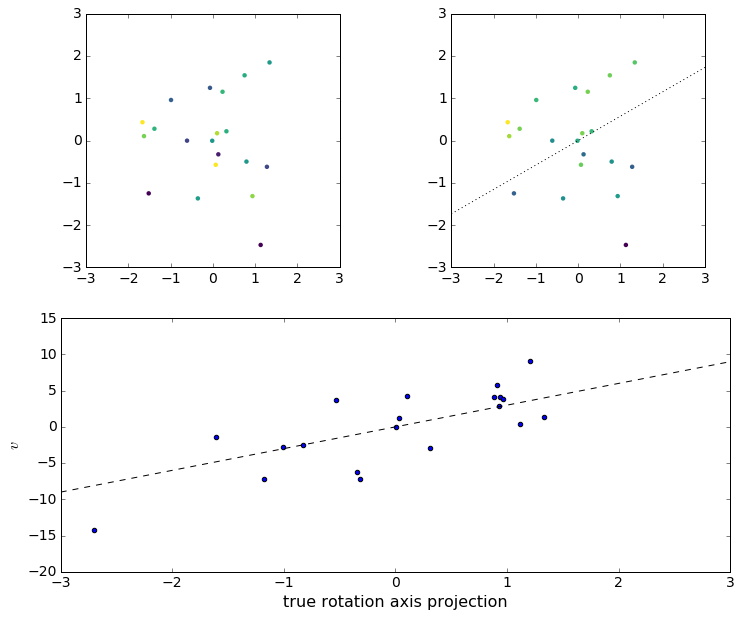

In [4]:
#show the result
fig = plt.figure(figsize=(12, 10))
ax1 = plt.subplot2grid((2, 2), (0, 0))
ax2 = plt.subplot2grid((2, 2), (0, 1))
ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2)

ax1.set_aspect(1)
ax1.scatter(x, y, c=norotdata, lw=0)
ax1.set_xlim(-3, 3)
ax1.set_ylim(-3, 3)


ax2.set_aspect(1)
ax2.plot([-3, 3], [-3, 3]*rot_axis[1]/rot_axis[0], ':k')
ax2.scatter(x, y, c=rotdata, lw=0)
ax2.set_xlim(-3, 3)
ax2.set_ylim(-3, 3)


rotax_proj = -np.cross(xys, rot_axis/rot_amplitude)
ax3.scatter(rotax_proj, rotdata)
ax3.plot([-3, 3], rot_amplitude*[-3,3], '--k')
ax3.set_xlim(-3, 3)
ax3.set_xlabel('true rotation axis projection')
ax3.set_ylabel('$v$')

# Fit models with and w/o rotation

In [5]:
GAUSS_TERM = -0.5*mlog(2*np.pi)
def gauss_lnp(data, mu, sig):
    return -0.5 * (((data - mu) / sig) ** 2 + 2 * np.log(sig)) + GAUSS_TERM

In [6]:
def chain_info_plots(sampler, burnin_chain, param_names, truths):
    plt.figure()
    fig, axs = plt.subplots(len(param_names),1)
    for ax, bchain, chain, nm, truth in zip(axs, burnin_chain.T, sampler.chain.T, param_names, truths):
        ax.plot(bchain, ls=':')
        ax.plot(np.arange(chain.shape[0]) + bchain.shape[0], chain)
        ax.axhline(truth, ls='--', c='k')
        ax.set_title(nm)
    fig.tight_layout()

    fig2 = corner.corner(sampler.flatchain, labels=param_names, truths=truths)
    fig2.tight_layout()
    
    return fig, fig2

## Without rotation 

In [7]:
def lnpri_norot(mu, sig):
    if not (-10 < mu < 10):
        return MINF
    if not (0 < sig < 10):
        return MINF
    
    return 0

def lnp_norot(p, data):
    mu, sig = p
    
    pri = lnpri_norot(mu, sig)
    if pri == MINF:
        return MINF
    
    return pri + np.sum(gauss_lnp(data, mu, sig))

/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:600: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)


(<matplotlib.figure.Figure at 0x113e769b0>,
 <matplotlib.figure.Figure at 0x11449a278>)

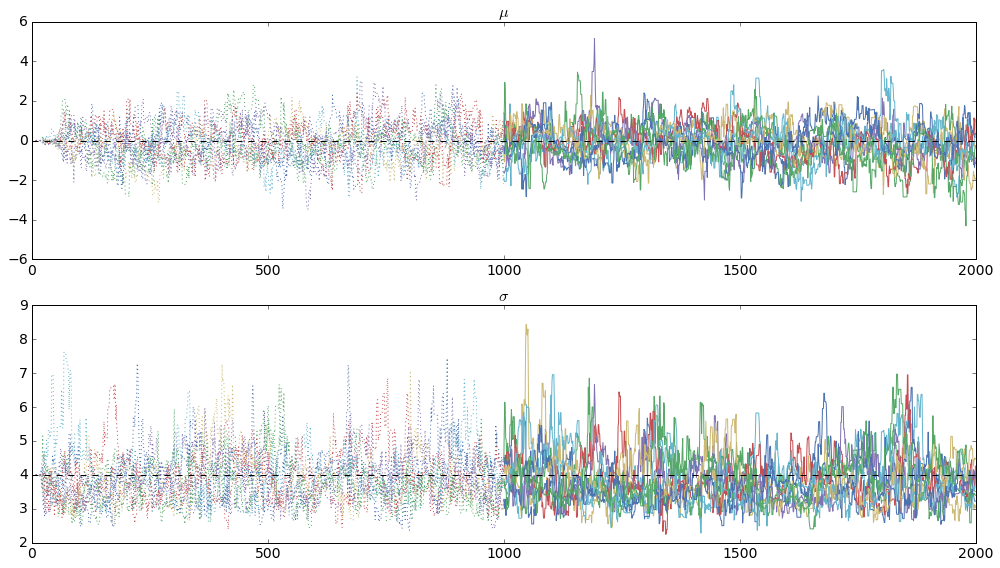

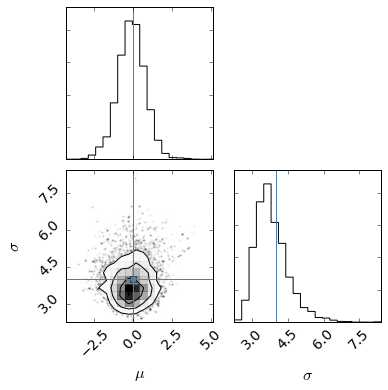

In [8]:
param_names = [r'$\mu$', r'$\sigma$']
truths = [0, sig.value]

sampler_norot = emcee.EnsembleSampler(10, 2, lnp_norot, args=[norotdata.to(u.km/u.s).value])
p0_norot = emcee.utils.sample_ball(truths, [1e-5]*len(truths), 10)

#burnin
p_burnin = sampler_norot.run_mcmc(p0_norot, 1000)[0]
burnin_chain = sampler_norot.chain
sampler_norot.reset()
res = sampler_norot.run_mcmc(p_burnin, 1000)



chain_info_plots(sampler_norot, burnin_chain, param_names, truths)

## With rotation 

In [9]:
from math import sin as msin, cos as mcos, radians as mrad

def lnpri_wrot(mu, sig, theta, v):
    if not (-10 < mu < 10):
        return MINF
    if not (0 < sig < 50):
        return MINF
    
    # v chose to not be negative, so theta goes all the way around
    if not (-180 < theta < 180):
        return MINF 
    if not (0 < v < 50):
        return MINF
    
    return 0

def rot_meanmodel(theta, v, xys):
    rtheta = mrad(theta)
    xrot = v*mcos(rtheta)
    yrot = v*msin(rtheta)
    rot_axis = [xrot, yrot]
    
    return np.cross(rot_axis, xys)

def lnp_wrot(p, vdata, xys):
    mu, sig, theta, v = p
    
    
    pri = lnpri_wrot(mu, sig, theta, v)
    if pri == MINF:
        return MINF
    
    vrot = rot_meanmodel(theta, v, xys)
    return pri + np.sum(gauss_lnp(vdata - vrot, mu, sig))


/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:600: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)


(<matplotlib.figure.Figure at 0x110e01e80>,
 <matplotlib.figure.Figure at 0x1156f8128>)

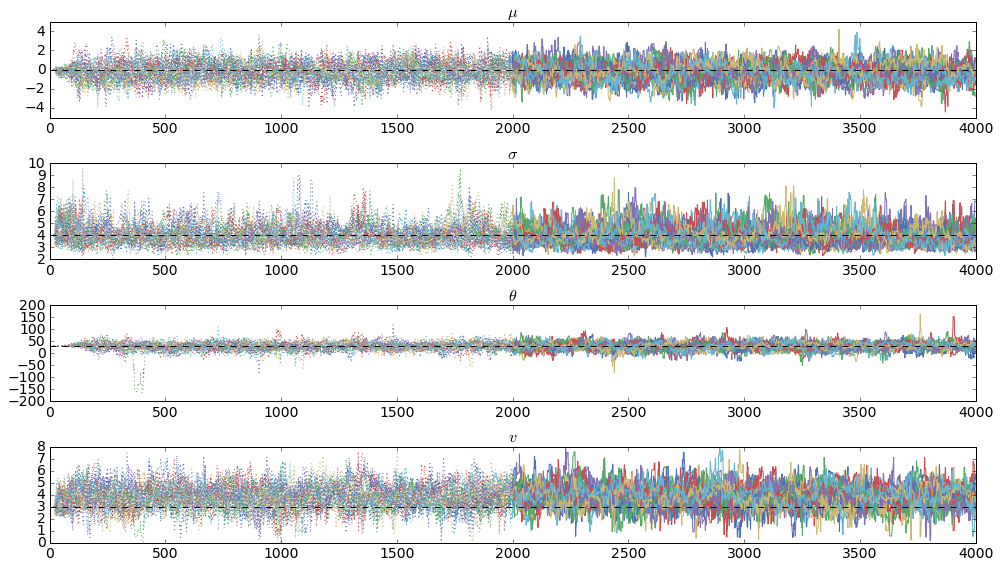

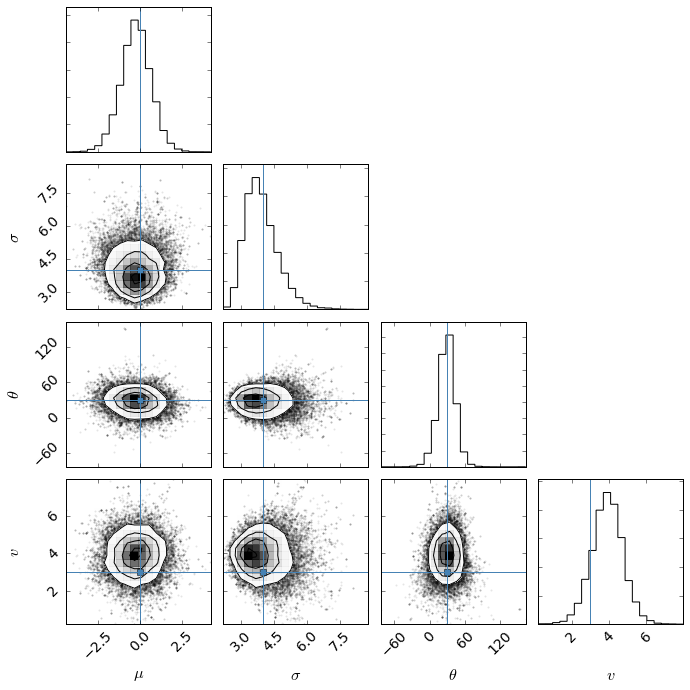

In [10]:
param_names = [r'$\mu$', r'$\sigma$', r'$\theta$', '$v$']
truths = [0, sig.value, rot_angle.value, rot_amplitude.value]

sampler_wrot = emcee.EnsembleSampler(24, 4, lnp_wrot, 
                                     args=[rotdata.to(u.km/u.s).value, xys.value])
p0_wrot = emcee.utils.sample_ball(truths, [1e-5]*len(truths), 24)

#burnin
p_burnin = sampler_wrot.run_mcmc(p0_wrot, 2000)[0]
burnin_chain = sampler_wrot.chain
sampler_wrot.reset()
res = sampler_wrot.run_mcmc(p_burnin, 2000)

chain_info_plots(sampler_wrot, burnin_chain, param_names, truths)

### Compare the velocity fields for the median model from above 

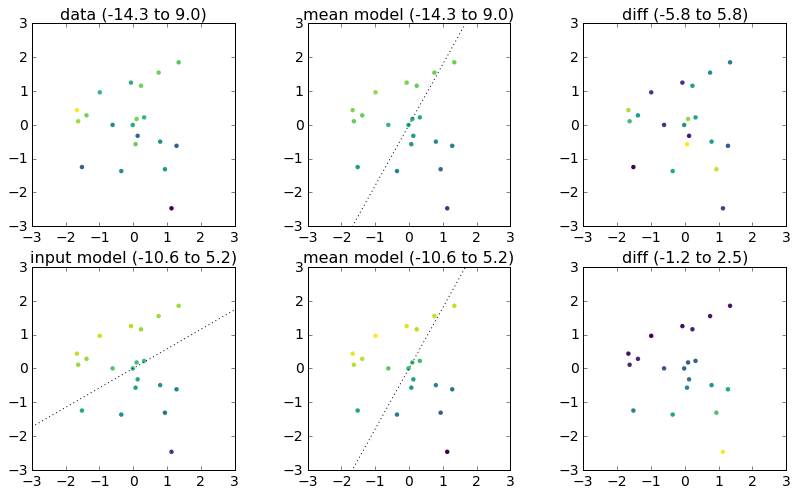

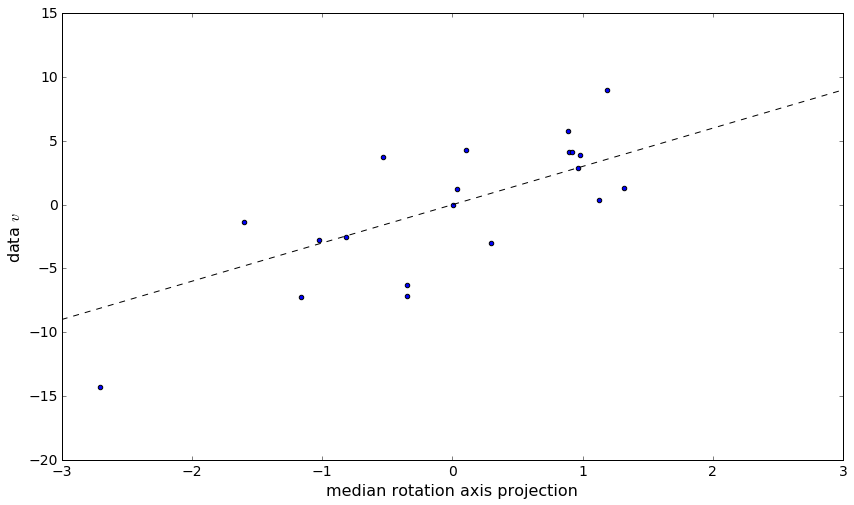

In [11]:
theta_m = np.median(sampler_wrot.flatchain[:, 2])
axis_x_m, axis_y_m = np.cos(theta_m*u.deg), np.sin(theta_m*u.deg)
axis_m = [axis_x_m, axis_y_m]/ np.hypot(axis_x_m, axis_y_m)
v_m = np.median(sampler_wrot.flatchain[:, 3])
vmod = rot_meanmodel(theta_m, v_m, xys.value)

fig, axss = plt.subplots(2, 3)
((ax1, ax2, ax3), (ax4, ax5, ax6)) = axss



vmin = np.min(np.concatenate((rotdata, vmod))).value
vmax = np.max(np.concatenate((rotdata, vmod))).value

sc = ax1.scatter(x, y, c=rotdata, lw=0, vmin=vmin, vmax=vmax)
ax1.set_title('data ({:.1f} to {:.1f})'.format(*sc.get_clim()))

sc = ax2.scatter(x, y, c=vmod, lw=0, vmin=vmin, vmax=vmax)
ax2.plot([-3, 3], [-3, 3]*axis_x_m/axis_y_m, ':k')
ax2.set_title('mean model ({:.1f} to {:.1f})'.format(*sc.get_clim()))

sc = ax3.scatter(x, y, c=rotdata.value-vmod, lw=0)
ax3.set_title('diff ({:.1f} to {:.1f})'.format(*sc.get_clim()))



vmin = np.min(np.concatenate((rotcomponent, vmod))).value
vmax = np.max(np.concatenate((rotcomponent, vmod))).value

sc = ax4.scatter(x, y, c=rotcomponent, lw=0, vmin=vmin, vmax=vmax)
ax4.plot([-3, 3], [-3, 3]*rot_axis[1]/rot_axis[0], ':k')
ax4.set_title('input model ({:.1f} to {:.1f})'.format(*sc.get_clim()))

sc = ax5.scatter(x, y, c=vmod, lw=0, vmin=vmin, vmax=vmax)
ax5.plot([-3, 3], [-3, 3]*axis_x_m/axis_y_m, ':k')
ax5.set_title('mean model ({:.1f} to {:.1f})'.format(*sc.get_clim()))

sc = ax6.scatter(x, y, c=rotcomponent.value-vmod, lw=0)
ax6.set_title('diff ({:.1f} to {:.1f})'.format(*sc.get_clim()))

for axs in axss:
    for ax in axs:
        ax.set_aspect(1)
        ax.set_xlim(-3, 3)
        ax.set_ylim(-3, 3)
        
plt.figure()
rotax_proj = -np.cross(xys, axis_m)
plt.scatter(rotax_proj, rotdata)
plt.plot([-3, 3], rot_amplitude*[-3,3], '--k')
plt.xlim(-3, 3)
plt.xlabel('median rotation axis projection')
plt.ylabel('data $v$')

# Now try the model *comparison* 

## The "model-switch" technique 

$q = [P(D|\theta, M_{rot})P(\theta|M_{rot})]^{\beta} [P(D|\theta, M_{norot})P(\theta|M_{norot})]^{1-\beta} $

In [12]:
def beta_model_lnp(p, vdata, xys, beta):
    mu, sig, theta, v = p
    
    lnp1 = lnp_norot((mu, sig), vdata)
    if lnp1 == MINF:
        return MINF, None
    lnp2 = lnp_wrot(p, vdata, xys)
    if lnp2 == MINF:
        return MINF, None
    
    return (1-beta) * lnp1 + beta * lnp2, (lnp1, lnp2)

### Try sampling from the beta=0 and beta=1 cases to make sure they reproduce the above 

/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:600: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)


(<matplotlib.figure.Figure at 0x117760d68>,
 <matplotlib.figure.Figure at 0x118ae9d30>)

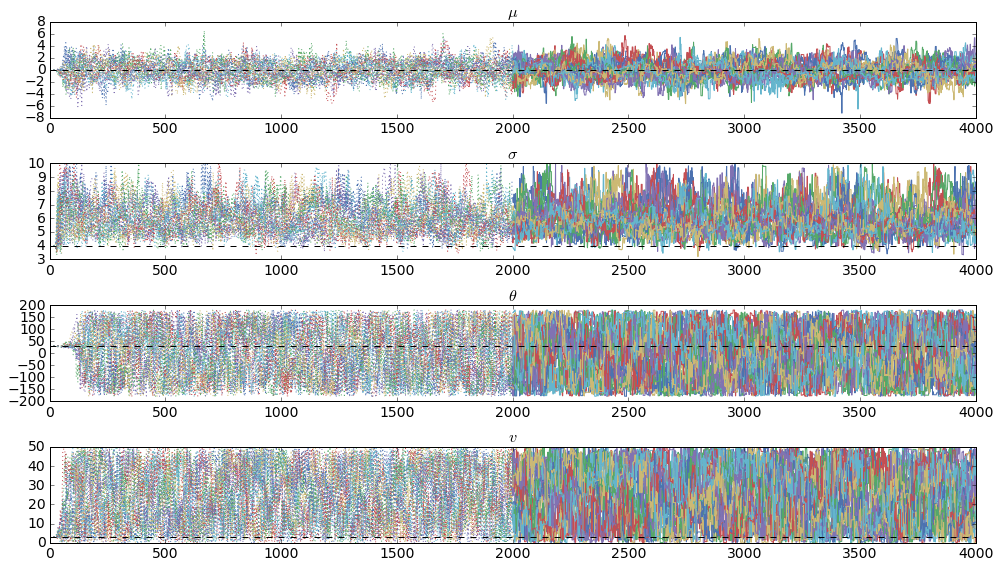

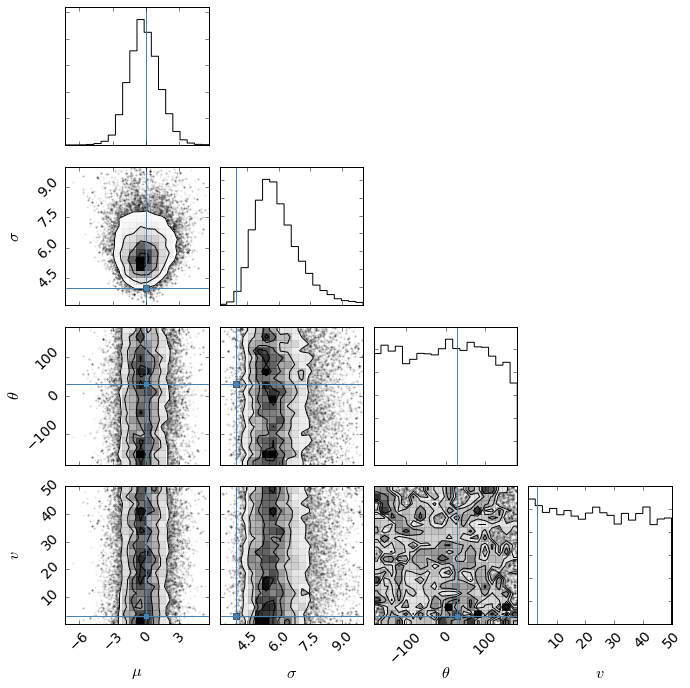

In [13]:
param_names = [r'$\mu$', r'$\sigma$', r'$\theta$', '$v$']
truths = [0, sig.value, rot_angle.value, rot_amplitude.value]

sampler_beta0 = emcee.EnsembleSampler(24, 4, beta_model_lnp, 
                                     args=[rotdata.to(u.km/u.s).value, xys.value, 0])
p0_beta0 = emcee.utils.sample_ball(truths, [1e-5]*len(truths), 24)

#burnin
p_burnin = sampler_beta0.run_mcmc(p0_beta0, 2000)[0]
burnin_chain = sampler_beta0.chain
sampler_beta0.reset()
res = sampler_beta0.run_mcmc(p_burnin, 2000)

chain_info_plots(sampler_beta0, burnin_chain, param_names, truths)

/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:600: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)


(<matplotlib.figure.Figure at 0x11a96e320>,
 <matplotlib.figure.Figure at 0x11b88bc88>)

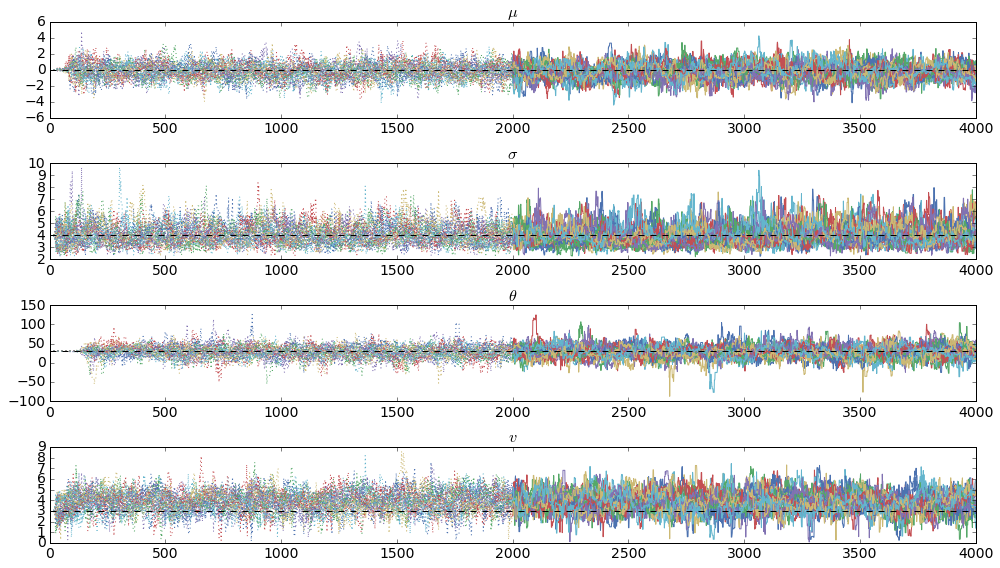

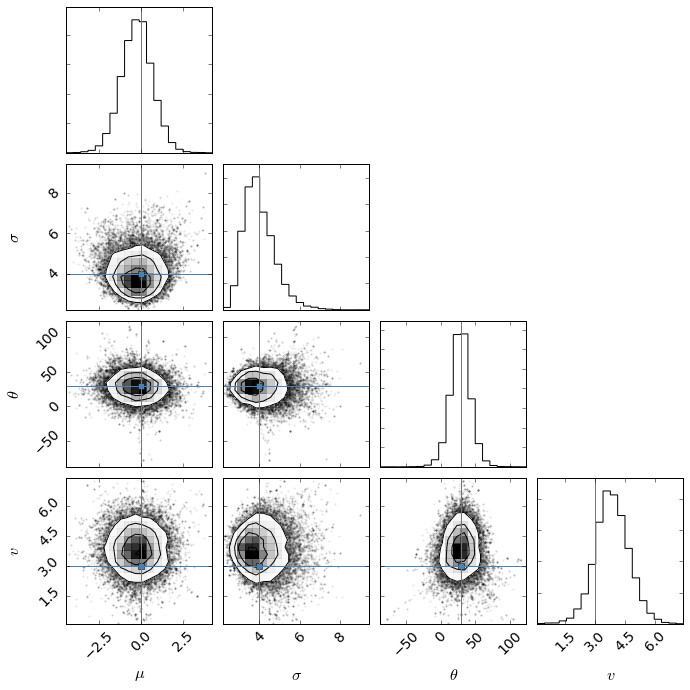

In [14]:
param_names = [r'$\mu$', r'$\sigma$', r'$\theta$', '$v$']
truths = [0, sig.value, rot_angle.value, rot_amplitude.value]

sampler_beta1 = emcee.EnsembleSampler(24, 4, beta_model_lnp, 
                                     args=[rotdata.to(u.km/u.s).value, xys.value, 1])
p0_beta1 = emcee.utils.sample_ball(truths, [1e-5]*len(truths), 24)

#burnin
p_burnin = sampler_beta1.run_mcmc(p0_beta1, 2000)[0]
burnin_chain = sampler_beta1.chain
sampler_beta1.reset()
res = sampler_beta1.run_mcmc(p_burnin, 2000)

chain_info_plots(sampler_beta1, burnin_chain, param_names, truths)

In [15]:
sampler_beta0.acor, sampler_beta1.acor

(array([ 41.35224455,  47.98137544,  39.48267629,  54.88689861]),
 array([ 42.08651589,  43.64221996,  45.34064861,  47.20457881]))

## Now use thermodynamic integration to compute the Bayes factor 

Model switch potential is:


$U \equiv \ln P(D|\theta, M_{rot})P(\theta|M_{rot})  - \ln P(D|\theta, M_{norot})P(\theta|M_{norot}) $

which means $>0$ -> $M_{rot}$ is favored 

In [16]:
def do_thermo_int(vdata, xyzs, truths, betas=1000, iburnin=200, ichain=100, nwalkers=24, samplerkwargs={}):
    """
    ``vdata`` should be (ndata,), ``xyzs`` should be (ndata, 2)
    """
    if isinstance(betas, int):
        betas = (np.logspace(0, 1, betas)-1)/(9)

    param_names = [r'$\mu$', r'$\sigma$', r'$\theta$', '$v$']

    args0 = [vdata.to(u.km/u.s).value, xys.value, 0]
    args1 = list(args0)
    args1[-1] = 1
    args = list(args0)  # used below 

    chains = []
    Us = []
    st0 = time.time()
    for i, beta in enumerate(betas):
        st = time.time()
        args[-1] = beta

        sampler_beta = emcee.EnsembleSampler(nwalkers, 4, beta_model_lnp, args=args, **samplerkwargs)
        p0_beta = emcee.utils.sample_ball(truths, [1e-5]*len(truths), nwalkers)

        #burnin for ~200 based on the above
        p_burnin = sampler_beta.run_mcmc(p0_beta, iburnin)[0]
        burnin_chain = sampler_beta.chain
        sampler_beta.reset()
        res = sampler_beta.run_mcmc(p_burnin, ichain)

        chains.append(sampler_beta.flatchain)

        blobs = np.array(sampler_beta.blobs)
        blobs = blobs.reshape(blobs.size//2, 2)
        lnp0 = blobs[:, 0]
        lnp1 = blobs[:, 1]
        Us.append(lnp1 - lnp0)
        et = time.time()

        print('', end='\r')
        print('On beta value', i+1, 'of', len(betas), 
              'which took', et-st, 'sec, implying',(len(betas)-i-1)*(et-st0)/60/(i+1),'min remaining', 
              end='')
    print('\rFinished', len(betas), 'betas in', (time.time()-st0)/60, 'min =',(time.time()-st0)/len(betas), 'sec per')
        
    Uintegral = integrate.simps(np.mean(Us, axis=1), betas)
    
    return Uintegral, betas, Us, chains

In [17]:
truths = [0, sig.value, rot_angle.value, rot_amplitude.value]

uints = []
bss = []
uss  = []
nbetas = (10, 10, 10, 20, 20, 20, 50, 50, 50, 100, 100, 100, 200, 200, 200, 400, 400, 400)
for nb in nbetas:
    Uintegral, betas, Us, _ = do_thermo_int(rotdata, xys, truths, betas=nb)
    uints.append(Uintegral)
    bss.append(betas)
    uss.append(Us)

Finished 10 betas in 0.06952584981918335 min = 0.4171551942825317 sec per
Finished 10 betas in 0.06990726788838704 min = 0.4194437026977539 sec per
Finished 10 betas in 0.06798959970474243 min = 0.4079375982284546 sec per
Finished 20 betas in 0.1387555996576945 min = 0.4162668466567993 sec per
Finished 20 betas in 0.1611610492070516 min = 0.4834831953048706 sec per
Finished 20 betas in 0.13925434748331705 min = 0.41776310205459594 sec per
Finished 50 betas in 0.36238731543223063 min = 0.43486479759216307 sec per
Finished 50 betas in 0.397435716787974 min = 0.4769228792190552 sec per
Finished 50 betas in 0.4486420830090841 min = 0.5383704996109009 sec per
Finished 100 betas in 0.6662587483723958 min = 0.3997552490234375 sec per
Finished 100 betas in 0.6863069176673889 min = 0.41178415060043333 sec per
Finished 100 betas in 0.6693665981292725 min = 0.40161996841430664 sec per
Finished 200 betas in 1.4332776506741842 min = 0.42998329997062684 sec per
Finished 200 betas in 1.37658498287200

The below plot is the thing that gets integrated

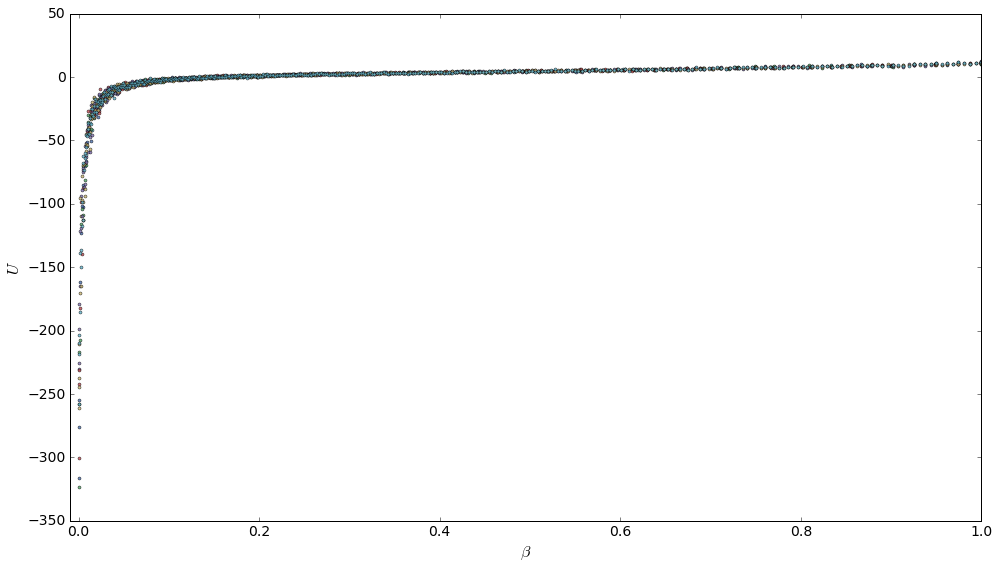

In [60]:
for i, (betas, Us) in enumerate(zip(bss, uss)):
    plt.plot(betas, np.mean(Us, axis=-1), 'o', alpha=.8, ms=3)
    
plt.xlim(-.01, 1)
plt.xlabel(r'$\beta$')
plt.ylabel(r'$U$')
plt.tight_layout()

This is the actual result of the integral for each set (or all together for the line):

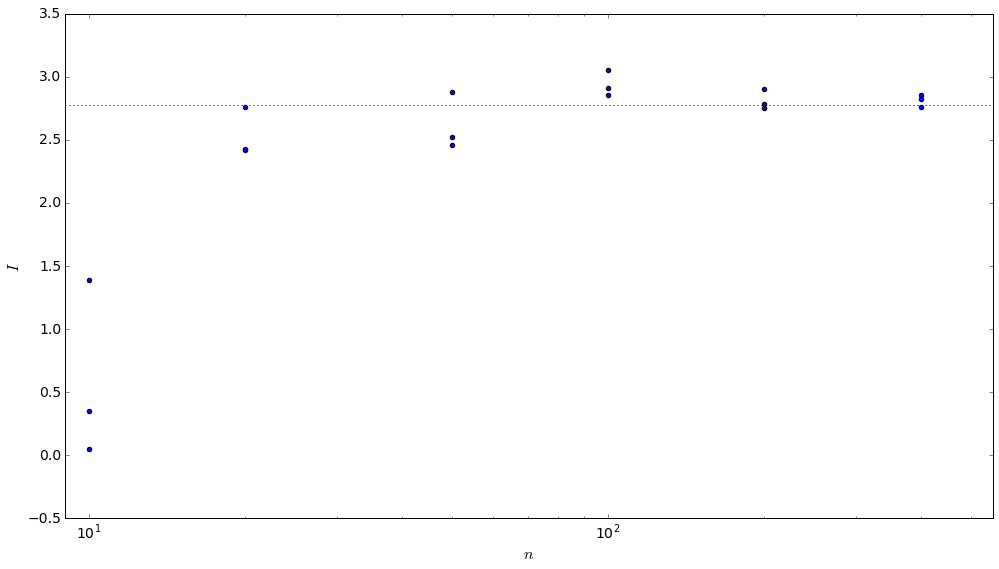

In [58]:
allmeanus = []
allbetas = []
for bs, us in zip(bss, uss):
    allmeanus.extend(np.mean(us, axis=-1))
    allbetas.extend(bs)
allbetas = np.array(allbetas)
allmeanus = np.array(allmeanus)
sorti = np.argsort(allbetas)
allint = integrate.trapz(allmeanus[sorti], allbetas[sorti])

plt.scatter(nbetas, uints)
plt.axhline(allint, c='k', ls=':')
plt.semilogx()
plt.xlim(9, 550)
plt.xlabel('$n$')
plt.ylabel('$I$')
plt.tight_layout()

## Try for a bunch of rotation datasets

In [20]:
def mock_dataset(nstars, sig, rot_angle, rot_amplitude, gal_size, size_lim):
    rot_axis = [np.cos(rot_angle), np.sin(rot_angle)]*rot_amplitude

    r = []
    while len(r) < nstars:
        r1 = special.erfinv(np.random.rand(nstars)) * 2**0.5 * gal_size
        if size_lim is not None:
            r1 = r1[r1<size_lim]
        r = np.concatenate((r, r1)).value*r1.unit
        r = r[:nstars]


    theta = np.random.rand(nstars)*360*u.deg

    x = r*np.cos(theta)
    y = r*np.sin(theta)
    xys = np.array((x, y.to(x.unit))).T * x.unit

    norotdata = np.random.randn(nstars)*sig


    # cross does not respect units, so we do this hacky thing to get the units right
    rotcomponent = np.cross(rot_axis, np.array((x, y)).T) * rot_axis.unit*x.unit
    rotdata = norotdata + rotcomponent
    
    return xys, norotdata, rotdata

In [84]:
print([nstars, sig, rot_angle, rot_amplitude, gal_size, size_lim])
xys, norotdata, rotdata = mock_dataset(nstars, sig, rot_angle, rot_amplitude, gal_size, size_lim)

Uintegral_wrot = do_thermo_int(rotdata, xys, truths, betas=250)[0]
Uintegral_nrot = do_thermo_int(norotdata, xys, truths, betas=250)[0]
Uintegral_wrot, Uintegral_nrot

[20, <Quantity 4.0 km / s>, <Quantity 30.0 deg>, <Quantity 3.0 km / (arcmin s)>, <Quantity 1.5 arcmin>, <Quantity 3.0 arcmin>]


(0.8814062439470187, -3.141880372126201)

In [80]:
xys, norotdata, rotdata = mock_dataset(nstars=50, sig=2*u.km/u.s, rot_angle=rot_angle, 
                                       rot_amplitude=6*u.km/u.s/u.arcmin, 
                                       gal_size=gal_size, size_lim=size_lim)
Uintegral_wrot = []
Uintegral_nrot = []
for i in range(4):
    Uintegral_wrot.append(do_thermo_int(rotdata, xys, truths, betas=200)[0])
    Uintegral_nrot.append(do_thermo_int(norotdata, xys, truths, betas=200)[0])
Uintegral_wrot, Uintegral_nrot

Finished 200 betas in 1.3705601652463277 min = 0.4111680495738983 sec per
Finished 200 betas in 1.2994120518366497 min = 0.38982362031936646 sec per
Finished 200 betas in 1.362754515806834 min = 0.40882635951042173 sec per
Finished 200 betas in 1.2942316969235739 min = 0.3882695150375366 sec per
Finished 200 betas in 1.3620627681414286 min = 0.40861883521080017 sec per
Finished 200 betas in 31.07550581693649 min = 9.322651745080949 sec per
Finished 200 betas in 1.3599067131678264 min = 0.4079720199108124 sec per
Finished 200 betas in 1.2995137015978495 min = 0.38985411047935487 sec per


([39.965628689763115,
  40.140711106018927,
  40.148097607055156,
  40.323335674700296],
 [-5.8858774991921763,
  -5.3104448580001202,
  -5.6098944319908002,
  -5.8028548800893258])

In [86]:
xys, norotdata, rotdata = mock_dataset(nstars=20, sig=2*u.km/u.s, rot_angle=rot_angle, 
                                       rot_amplitude=8*u.km/u.s/u.arcmin, 
                                       gal_size=gal_size, size_lim=size_lim)
Uintegral_wrot = []
Uintegral_nrot = []
for i in range(8):
    Uintegral_wrot.append(do_thermo_int(rotdata, xys, truths, betas=200)[0])
    Uintegral_nrot.append(do_thermo_int(norotdata, xys, truths, betas=200)[0])
Uintegral_wrot, Uintegral_nrot

Finished 200 betas in 1.3221208333969117 min = 0.3966362547874451 sec per
Finished 200 betas in 1.3224629680315654 min = 0.3967388904094696 sec per
Finished 200 betas in 1.3153437813123068 min = 0.394603134393692 sec per
Finished 200 betas in 1.3252806504567465 min = 0.3975841999053955 sec per
Finished 200 betas in 1.3094393173853556 min = 0.3928317952156067 sec per
Finished 200 betas in 1.3178910692532857 min = 0.39536732077598574 sec per
Finished 200 betas in 1.3119418501853943 min = 0.3935825550556183 sec per
Finished 200 betas in 1.3266672650973002 min = 0.3980001795291901 sec per
Finished 200 betas in 1.3261243502298992 min = 0.39783730506896975 sec per
Finished 200 betas in 1.3216383139292398 min = 0.396491494178772 sec per
Finished 200 betas in 1.3274497985839844 min = 0.3982349455356598 sec per
Finished 200 betas in 1.3200233499209086 min = 0.39600700974464415 sec per
Finished 200 betas in 1.3265284657478333 min = 0.39795853972434997 sec per
Finished 200 betas in 1.321983333428

([20.974019474032122,
  21.153779993749481,
  20.884348773413571,
  21.194598796460085,
  21.020725280724388,
  20.882813439747025,
  20.760415456997769,
  20.989790509558318],
 [-3.5066523367248599,
  -2.8955940320680553,
  -3.3294442797382646,
  -3.1878863882853392,
  -3.5721564952028291,
  -3.2093365752636664,
  -3.3566296722575757,
  -3.3467281334208634])

In [87]:
xys, norotdata, rotdata = mock_dataset(nstars=50, sig=5*u.km/u.s, rot_angle=rot_angle, 
                                       rot_amplitude=4*u.km/u.s/u.arcmin, 
                                       gal_size=gal_size, size_lim=size_lim)
Uintegral_wrot = []
Uintegral_nrot = []
for i in range(8):
    Uintegral_wrot.append(do_thermo_int(rotdata, xys, truths, betas=200)[0])
    Uintegral_nrot.append(do_thermo_int(norotdata, xys, truths, betas=200)[0])
Uintegral_wrot, Uintegral_nrot

Finished 200 betas in 1.3231198827425639 min = 0.39693596482276916 sec per
Finished 200 betas in 1.2727319995562236 min = 0.3818195998668671 sec per
Finished 200 betas in 1.3228960990905763 min = 0.39686883449554444 sec per
Finished 200 betas in 1.271719714005788 min = 0.3815159142017365 sec per
Finished 200 betas in 1.320891014734904 min = 0.3962673091888428 sec per
Finished 200 betas in 1.268965764840444 min = 0.3806897342205048 sec per
Finished 200 betas in 1.3228497505187988 min = 0.39685492515563964 sec per
Finished 200 betas in 1.271349596977234 min = 0.38140487909317017 sec per
Finished 200 betas in 1.3218215505282085 min = 0.3965464699268341 sec per
Finished 200 betas in 1.2687961181004843 min = 0.38063884019851685 sec per
Finished 200 betas in 1.3201924681663513 min = 0.39605774521827697 sec per
Finished 200 betas in 1.267340366045634 min = 0.38020211458206177 sec per
Finished 200 betas in 1.3205727815628052 min = 0.3961718392372131 sec per
Finished 200 betas in 1.271762299537

([8.0098089900786267,
  8.1090733623674929,
  8.0678951434327413,
  8.0294242813501366,
  8.1555000096808605,
  8.0462435277119866,
  7.9248851361880961,
  8.0254249787097791],
 [-4.1469870289923927,
  -3.7103627992018344,
  -3.8090347149677091,
  -4.0097546392882357,
  -3.5729716417201902,
  -3.7936261090576346,
  -3.8125860434645777,
  -3.9697037896422147])

In [88]:
xys, norotdata, rotdata = mock_dataset(nstars=20, sig=7*u.km/u.s, rot_angle=rot_angle, 
                                       rot_amplitude=3*u.km/u.s/u.arcmin, 
                                       gal_size=gal_size, size_lim=size_lim)
Uintegral_wrot = []
Uintegral_nrot = []
for i in range(8):
    Uintegral_wrot.append(do_thermo_int(rotdata, xys, truths, betas=200)[0])
    Uintegral_nrot.append(do_thermo_int(norotdata, xys, truths, betas=200)[0])
Uintegral_wrot, Uintegral_nrot

Finished 200 betas in 1.2368465979894003 min = 0.37105397939682006 sec per
Finished 200 betas in 1.2321006178855896 min = 0.3696301853656769 sec per
Finished 200 betas in 1.2361405849456788 min = 0.37084217548370363 sec per
Finished 200 betas in 1.2343353827794392 min = 0.37030062079429626 sec per
Finished 200 betas in 1.2348535815874735 min = 0.37045607447624207 sec per
Finished 200 betas in 1.2367927352587382 min = 0.37103782534599306 sec per
Finished 200 betas in 1.2354285319646199 min = 0.370628559589386 sec per
Finished 200 betas in 1.232185999552409 min = 0.36965580463409425 sec per
Finished 200 betas in 1.233092999458313 min = 0.36992790579795837 sec per
Finished 200 betas in 1.2308955669403077 min = 0.3692686748504639 sec per
Finished 200 betas in 1.234283483028412 min = 0.37028504490852354 sec per
Finished 200 betas in 1.2347959677378337 min = 0.37043879508972166 sec per
Finished 200 betas in 1.2364696661631267 min = 0.3709409058094025 sec per
Finished 200 betas in 1.234558816

([1.334853167145658,
  1.2832078993301419,
  1.3893950796604706,
  1.3765640699358608,
  1.3230514691567838,
  1.2822695985731838,
  1.2517813565007943,
  1.3098266747855136],
 [-1.0403629913937367,
  -1.1855646411002454,
  -1.2021883366033621,
  -1.0816441074479244,
  -1.132672963923339,
  -1.0481654637560525,
  -1.2078932129150619,
  -1.2223796334001082])

# "Appendix": Testing numerical integration via a similar-looking analytic integral

$f = -1/(x+a)$

$\int f dx= - \ln (x+a)$

((1.38487948315874, 1.0771572941907594e-10), -1.1102230246251565e-15)

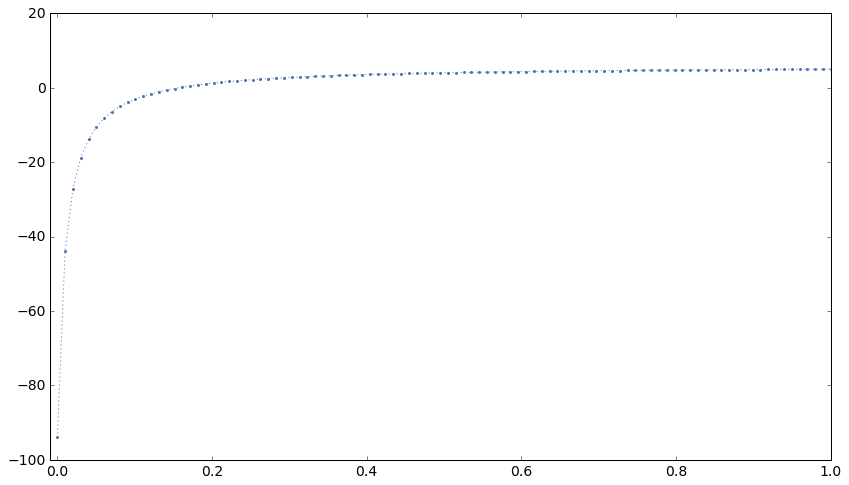

In [22]:
A = 6
a = .01
f = lambda x:A-1/(x+a)
fi = lambda x:A*x-np.log(x+a)

x = np.linspace(0,1,100)
plt.plot(x, f(x), 'o:', ms=3, mew=0)
plt.xlim(-.01, 1)

true_integral = fi(1)-fi(0)
integrate.quad(f, 0, 1), integrate.quad(f, 0, 1)[0] - true_integral

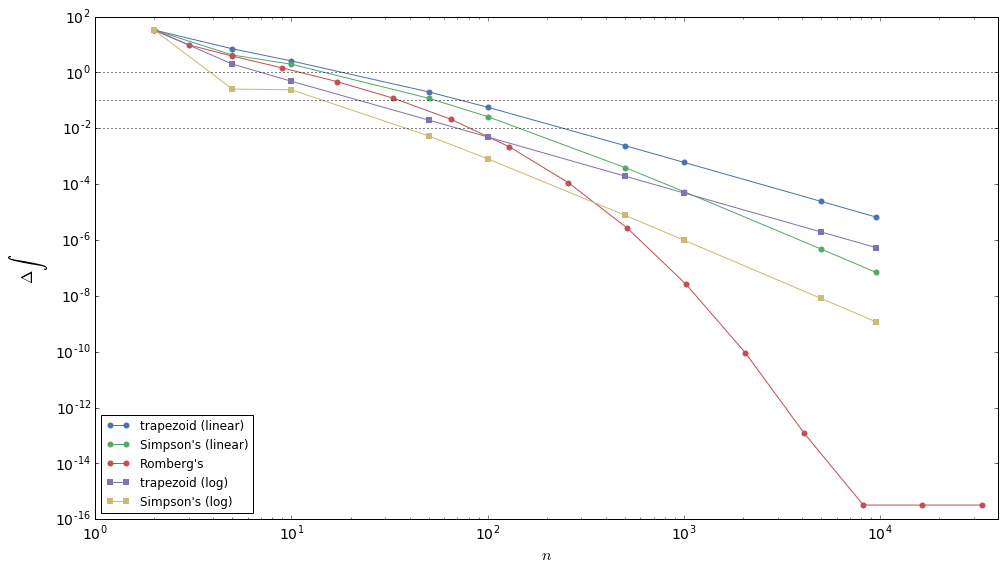

In [23]:
ns = (2, 5, 10, 50, 100, 500, 1000, 5000, 9500)
diffs_trapz = []
diffs_simps = []
diffsl_trapz = []
diffsl_simps = []
for n in ns:
    x = np.linspace(0,1, n)
    diffs_trapz.append(integrate.trapz(f(x), x) - true_integral)
    diffs_simps.append(integrate.simps(f(x), x) - true_integral)
    
    xl = (np.logspace(0, 1, n)-1)/9
    diffsl_trapz.append(integrate.trapz(f(xl), xl) - true_integral)
    diffsl_simps.append(integrate.simps(f(xl), xl) - true_integral)
    
plt.loglog(ns, np.abs(np.array(diffs_trapz)/true_integral), 'o-',mew=0, label='trapezoid (linear)')
plt.loglog(ns, np.abs(np.array(diffs_simps)/true_integral), 'o-', mew=0, label='Simpson\'s (linear)')

nromb = 1+2**np.arange(16)
diffs_romb = []
for n in nromb:
    xr = np.linspace(0, 1, n)
    diffs_romb.append(integrate.romb(f(xr), dx=np.diff(xr).mean()) - true_integral)
plt.loglog(nromb, np.abs(np.array(diffs_romb)/true_integral), 'o-', mew=0, label='Romberg\'s')

plt.loglog(ns, np.abs(np.array(diffsl_trapz)/true_integral), 's-',mew=0, label='trapezoid (log)')
plt.loglog(ns, np.abs(np.array(diffsl_simps)/true_integral), 's-', mew=0, label='Simpson\'s (log)')

plt.axhline(1,c='k',ls=':')
plt.axhline(.1,c='k',ls=':') # 10%
plt.axhline(.01,c='k',ls=':') # 1%

plt.legend(loc=0)
plt.xlabel('$n$')
plt.ylabel(r'$\Delta \int$')
plt.xlim(1, 10**4.6)
plt.tight_layout()

In [24]:
# timing test
n = 1+2**10
print(np.log10(n))
x = np.linspace(0, 1, n)
dx = np.diff(x).mean()
y = f(x)
%timeit integrate.trapz(y, x)
%timeit integrate.simps(y, x)
%timeit integrate.romb(y, dx)

3.01072386539
100000 loops, best of 3: 17.9 µs per loop
10000 loops, best of 3: 43.2 µs per loop
10000 loops, best of 3: 93.2 µs per loop


For the $\sim n = 10-1000$ cases, logarithmic Simson's seems the best choice